## Design of this workbook

### Problem Statment
We made a synthetic imbalanced data set by dropping the majority of the positive samples of the Bone-and-Joint deep dive data

### Design of the solution
0. Baseline model
    - Dummy classifier
    - Vanilla lightGBM
1. Pre-processing
    - SMOT(0.1) + random undersampling(0.5)
    - Pos_class_weights
2. Optimized objective function
    - Cost optimized
    - focal loss for f1 optimization
3. Post-processing
    - Change decisioon threshold on Vanilla lightGBM output to maximize F1/AUC
    - Change decisioon threshold on focal loss algorithm output to minimize cost

### Changing post and benefit ratio to show variations
- point 1
- point 2
- point 3
- point 4

In [109]:
import os
import pickle
import pandas as pd
import numpy as np
from numpy import where
from numpy import mean

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold,ShuffleSplit

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
#from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline

from collections import Counter
#from sklearn.datasets import make_classification
from matplotlib import pyplot

import hyperopt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import lightgbm as lgbm
from sklearn.dummy import DummyClassifier
#from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict,ShuffleSplit
#from imblearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import bernoulli
import math



NPSEED = 1337
np.random.seed(NPSEED)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Prototype 1: Unequal value in each sample

#### Step 1. Simulate sample data set
1. 10000 samples
2. pos_rate =0.4, Bernoulli distribution
3. Value in each sample ~ logN(500,200), or N(500,100)

In [176]:
# Define Benefit function for correctly classify objectives
# We consider the scenario of churn prediction, where correctly identify positive cases means 
# capturing otherwise lost revenue at the expense of preventitive actions

def Benefit(y_true, B_p, B_n):
    
    benefit = np.where( y_true==1,1,0)*B_p+np.where( y_true==0,1,0)*B_n
    #print('Benefit:\t',benefit[:20])
    return np.mean(benefit)


############################################
# Define NetBenefit = Benefit - Cost
# Assyming df has three col: vlaue, label, and prediction -- in this order


def NetBenefit(df, B_percent, C_percent):
    NetBenefit= sum(df[(df.label==df.prediction)&(df.label==1)].value*(B_percent))\
    -sum(df[df.prediction==1].value*(C_percent))

    return NetBenefit





In [247]:
############################################
#  Simulate Sample data
#  Input: NumSample
#         Value_Dist: Normal or LogNormal
#         Pos_rate
#  Output: simulated sample set with value and label


def SimulateSample(n,p,mu,sigma,DisType='Normal'):
    # Simulate positive label
    np.random.seed(30)
    label = bernoulli.rvs(p, size=n)
    print('Number of psotitive label:\t',label.sum(),'\n')


    # Simulate value of the sample data
    np.random.seed(30)
    ## For normal
    if DisType == 'Normal':
        value = np.random.normal(mu, sigma, n)
    ## For lognormal
    elif DisType == 'LogNormal':
        value = np.random.lognormal(mu, sigma, n)
    else:
        value = np.random.uniform(mu-sigma, mu+sigma, n)

    
    sample = pd.DataFrame(data=np.column_stack((value,label)), columns=["value", "label"])
    
    # Exam output, can be omitted
    print('The length of the sample is:\t', len(sample))
    print('Max value is:\t',value.max().round(2))
    print('Min value is:\t',value.min().round(2))
    print('Avg value is:\t',value.mean().round(2),'\n')
    print("Sample head\n",sample.head(10).round(2),'\n')


    return sample



In [212]:
############################################
#  Simulate Predictions that satisfies give sensitivity and specificity
#  Input:  Sample data
#          sensitivity \in [0,1]
#          specificity \in [0,1]
# Output:  Simulated prediction, that satisfies given sensitivity and specificity

def SimulatePrediction(data, sensitivity, specificity):

    ########################################
    # Make a copy of the sample df
    # Add a prediction col to the copy: defult = zero
    data_w_prediction = data.copy()
    prediction = np.zeros(len(data))
    data_w_prediction['prediction'] = prediction

    ########################################
    # Split Sample
    # Input: Sample data
    # Output: Split sample data into Positive and Negative parts

    data_pos = data_w_prediction[data_w_prediction['label'] >= 0.5] # May not be needed
    data_neg = data_w_prediction[data_w_prediction['label'] < 0.5]  # May not be needed
    #print("Positive sample\n",data_pos.head(5),'\n')
    #print("Negative sample\n",data_neg.head(10),'\n')

    pos_index = data_w_prediction.index[data_w_prediction['label'] >= 0.5].tolist()
    neg_index = data_w_prediction.index[data_w_prediction['label'] < 0.5].tolist()
    #print("Positive index\n",pos_index,'\n')
    #print("Negative index\n",neg_index,'\n')


    ###############################################
    # Simulate the index for positive predictions
    Index_true_pos=np.random.choice(np.array(pos_index), \
                  int(len(pos_index)*sensitivity), replace = False).tolist()
    Index_false_neg=np.random.choice(np.array(neg_index), \
                  int(len(neg_index)*(1-specificity)), replace = False).tolist()


    #print('ResampleIndex_pos\t',Index_true_pos,'\n')
    #print('ResampleIndex_neg\t', Index_false_neg,'\n')

    # Update prediction
    data_w_prediction.loc[[*Index_true_pos,*Index_false_neg],'prediction']=1

    return data_w_prediction

In [227]:
############################################
# Estimate trails of returns (net benefit) of the simulated predictions

def SimulateValueMatrix(df,nSens,nSpec, B_pos, C_pos):

    value_matrix_list =[]

    for trial in range(nTrail):
        for sensitivity in np.linspace(0.005, 0.995, num=nSens).round(2):
            for specificity in np.linspace(0.005, 0.995, num=nSpec).round(2):
                df_w_prediction = SimulatePrediction(df, sensitivity, specificity)
                benefit = NetBenefit(df_w_prediction, B_pos, C_pos)
                value_matrix_list.append([sensitivity,specificity,benefit])
    return value_matrix_list



In [248]:
############################################
# Simulate sample data
n=5000
p=0.4

## For lognormal
mu=math.log(500)
sigma=0.5

## For normal
#mu=500
#sigma=100

sample = SimulateSample(n,p,mu,sigma,DisType='LogNormal')

Number of psotitive label:	 2034 

The length of the sample is:	 5000
Max value is:	 2869.95
Min value is:	 92.68
Avg value is:	 572.23 

Sample head
      value  label
0   265.76    1.0
1  1073.37    0.0
2   307.74    1.0
3   632.63    0.0
4   475.45    1.0
5   582.02    0.0
6   210.95    1.0
7  1104.51    0.0
8   534.73    0.0
9   287.49    0.0 



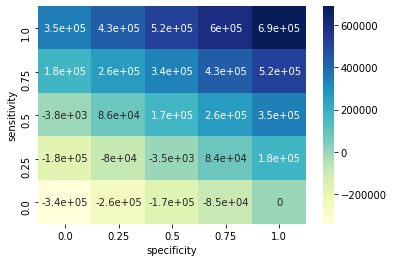

In [252]:
############################################

sens_step = 5
spec_step = 5

benefit_pos =0.8
cost_pos = 0.2

nTrail=1

value_matrix_list = SimulateValueMatrix(sample,sens_step,spec_step, benefit_pos, cost_pos)

# Generate heat map of the simulated returnd
value_matrix_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'return'], data=value_matrix_list)
value_matrix_df = value_matrix_df.pivot_table(index=["sensitivity"], \
                                              columns=["specificity"],values="return", aggfunc=np.median) # or np.median
value_matrix_df = value_matrix_df.sort_index(ascending=False)

#value_matrix_df = value_matrix_df.pivot("sensitivity", "specificity","return")
#print(value_matrix_df,'\n')


ax = sns.heatmap(value_matrix_df,annot=True, cmap="YlGnBu")
#ax = sns.heatmap(value_matrix_df, cmap="YlGnBu")

### Prototype 0: Equal value in each sample

In [72]:
Total = 10000
pos_rate =0.3
neg_rate = 1- pos_rate
Benefit_TP = 2
Cost_P =1

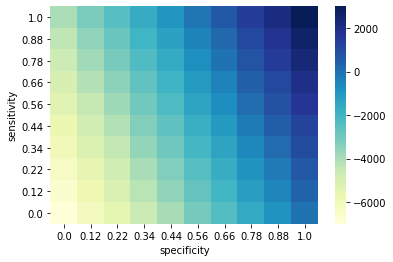

In [75]:
#import numpy as np
sens_step = 10
spec_step = 10

value_matrix_list =[]
for sensitivity in np.linspace(0.005, 0.995, num=sens_step).round(2):
    for specificity in np.linspace(0.005, 0.995, num=spec_step).round(2):
        TP = Total*pos_rate * sensitivity
        TN = Total*neg_rate * specificity
        FP = Total*neg_rate - TN
        FN = Total*pos_rate - TP
        benefit = Benefit_TP*TP-Cost_P*(TP+FP)
        value_matrix_list.append([sensitivity,specificity,benefit])


value_matrix_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'return'], data=value_matrix_list)
value_matrix_df = value_matrix_df.pivot_table(index=["sensitivity"], columns=["specificity"],values="return")
value_matrix_df = value_matrix_df.sort_index(ascending=False)

#value_matrix_df = value_matrix_df.pivot("sensitivity", "specificity","return")
#print(value_matrix_df,'\n')


#ax = sns.heatmap(value_matrix_df,annot=True, cmap="YlGnBu")
ax = sns.heatmap(value_matrix_df, cmap="YlGnBu")